# Determination of ratio D in Forward Field Calculation using Variable Density Tesseroid

Our intention is to determine the ratio D needed to get an acceptable precission in the calculation of gravity fields using tesseroids with variable density that depends linearly on depth.

$\rho(h) = a h + b$

In order to do this, we are going to take into account an spherical shell with inner and outer radii $R_1$ and $R_2$, respectivetly. We will perform the fields calculation for different values of D and compare them with the analytical solutions obtained in the "spherical_shell_variable_density" notebook:

\begin{equation}
V(r) = \pi Ga \frac{R_2^4 - R_1^4}{r} + \frac{4}{3}\pi G b\frac{R_2^3 - R_1^3}{r}
\end{equation}

Due to the nature of the numerical approximation of the tesseroid field by point masses located in the nodes of the GLQ, the fields can vary between computation points at the same height but at different longitude, latitude locations. Because of this we will evaluate the fields in a small grid and the comparation will be made by calculating the maximum difference between the analytical solution and these computation points.


**Import Packages**

In [71]:
from __future__ import division
import os
import time
import numpy as np
from tesseroid_density import tesseroid
from fatiando.constants import G, MEAN_EARTH_RADIUS, SI2MGAL, SI2EOTVOS
from fatiando.mesher import Tesseroid, TesseroidMesh
from fatiando import gridder
import matplotlib.pyplot as plt

%matplotlib inline

**Configuration for Pyplot Figures**

In [32]:
plt.rcParams['axes.labelsize'] = 9.0 # fontsize of the x any y labels
plt.rcParams['xtick.labelsize'] = 9.0 # fontsize of the tick labels
plt.rcParams['ytick.labelsize'] = 9.0 # fontsize of the tick labels
plt.rcParams['legend.fontsize'] = 9.0
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = 'Computer Modern Roman'
plt.rcParams['text.usetex'] = True # use latex for all text handling
plt.rcParams['text.color'] = '3a3a3a'
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['axes.linewidth'] = 1
plt.rcParams['axes.edgecolor'] = '3a3a3a'
plt.rcParams['axes.facecolor'] = 'white'
plt.rcParams['lines.linewidth'] = 1
plt.rcParams['lines.markersize'] = 4
plt.rcParams['xtick.major.size'] = 2
plt.rcParams['ytick.major.size'] = 2

**Definition of linear density function**

In [2]:
a = 1
b = 0

def density_linear(height):
    r = height + MEAN_EARTH_RADIUS
    return a*r + b

**Definition of spherical shell potential function**

In [3]:
def shell_linear_density(height, top, bottom, a, b):
    r = height + MEAN_EARTH_RADIUS
    r1 = bottom + MEAN_EARTH_RADIUS
    r2 = top + MEAN_EARTH_RADIUS
    constant = np.pi*G*a*(r2**4 - r1**4) + 4/3.*np.pi*G*b*(r2**3 - r1**3)
    potential = constant/r
    data = {'potential': potential,
            'gx': 0,
            'gy': 0,
            'gz': SI2MGAL*(potential/r),
            'gxx': SI2EOTVOS*(-potential/r**2),
            'gxy': 0,
            'gxz': 0,
            'gyy': SI2EOTVOS*(-potential/r**2),
            'gyz': 0,
            'gzz': SI2EOTVOS*(2*potential/r**2)}
    return data

**Definition of Spherical Shell and Tesseroid Model**

In [4]:
top, bottom = -3000, -50000
model = TesseroidMesh((0, 360, -90, 90, top, bottom), (1, 6, 12))
model.addprop("density", [density_linear for i in range(model.size)])

**Determination of D for different grids**

In [91]:
shape = (10, 10)
grids = {"pole": gridder.regular((89, 90, 0, 1), shape, z=2e3),
         "equator": gridder.regular((0, 1, 0, 1), shape, z=2e3),
         "260km": gridder.regular((89, 90, 0, 1), shape, z=260e3),
         "30deg": gridder.regular((60, 90, 0, 30), shape, z=2e3)}
fields = 'potential gz gzz'.split()
D_values = np.arange(0.5, 10.5, 0.5)

for field in fields:
    for grid in grids.keys():
        lons, lats, heights = grids[grid]
        analytical = shell_linear_density(heights[0], top, bottom, a, b)
        diffs = []
        for D in D_values:
            result = getattr(tesseroid, field)(lons, lats, heights, model, ratio=D)
            diff = np.abs(result - analytical[field])/np.abs(analytical[field])
            diff = 100*np.max(diff)
            diffs.append(diff)
        diffs = np.array(diffs)
        np.savez('../data/' + field + '-' + grid + '-differences.npz',
                 D_values=D_values, diffs=diffs)

**Plot results**

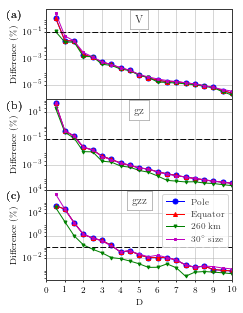

In [119]:
grids = ['pole', 'equator', '260km', '30deg']
fields = 'potential gz gzz'.split()
styles = ['-o', '-^', '-v', '-s']
msize = [5, 4, 3, 2]
colors = ['b', 'r', 'g', 'm']
labels = [r'Pole', r'Equator', r'260 km', r'$30^\circ$ size']
titles = 'V gz gzz'.split()
subfigure = '(a) (b) (c)'.split()

fig, axes = plt.subplots(nrows=len(fields), ncols=1, sharex=True)
fig.set_size_inches((3.33, 5))
fig.subplots_adjust(hspace=0)
for ax, field, title, sub in zip(axes, fields, titles, subfigure):
    for grid, style, c, label, ms in zip(grids, styles, colors, labels, msize):
        diffs = np.load('../data/' + field + '-' + grid + '-differences.npz')
        D_values, analytical = diffs['D_values'], diffs['diffs']
        ax.plot(D_values, analytical, style, markersize=ms,
                color=c, label=label)
        ax.text(-0.21, 0.9, sub, fontsize=12,
                fontdict={'weight': 'bold'},
                transform=ax.transAxes)
        ax.text(0.5, 0.88, title, fontsize=11,
                horizontalalignment='center',
                verticalalignment='center',
                bbox={'facecolor': 'w',
                      'edgecolor': '#9b9b9b',
                      'linewidth': 0.5, 'pad': 5},
                transform=ax.transAxes)
        ax.plot([-1, 11], [1e-1, 1e-1], '--',
                color='k', linewidth=0.5)
        ax.set_yscale('log')
        ax.set_yticks(ax.get_yticks()[2:-2])
        ax.set_ylabel('Difference (\%)')
        ax.grid(True, linewidth=0.5, color='#aeaeae')
        ax.set_axisbelow(True)
ax = axes[-1]
ax.set_xlabel(r"D")
ax.set_xlim(0, 10)
ax.set_xticks(np.arange(0, 11, 1))
ax.legend()
plt.savefig('../figs/differences.svg')
plt.show()